# Importamos librerias que usaremos

In [447]:
!pip install 'dtreeviz'
import pandas as pd
import numpy as np

#Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import dtreeviz

#modelos y métricas
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score#, precision_recall_curve, roc_curve,
from sklearn.metrics import confusion_matrix, classification_report

#preprocesamiento
from sklearn.preprocessing import MinMaxScaler

#configuración warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# Recuperacion de dataSets que se usaran para entrenar al modelo


In [448]:
#Importamos dataSet de entrenamiento
data = pd.read_csv('./dsHotelCHP1.csv', on_bad_lines='skip')
ds_trabajo = data.copy()

ds_trabajo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60414 entries, 0 to 60413
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           60414 non-null  object 
 1   lead_time                       60414 non-null  int64  
 2   arrival_date_year               60414 non-null  int64  
 3   arrival_date_month              60414 non-null  int64  
 4   arrival_date_day_of_month       60414 non-null  int64  
 5   stays_in_weekend_nights         60414 non-null  int64  
 6   stays_in_week_nights            60414 non-null  int64  
 7   adults                          60414 non-null  int64  
 8   children                        60414 non-null  int64  
 9   babies                          60414 non-null  int64  
 10  meal                            60414 non-null  object 
 11  country                         60414 non-null  object 
 12  market_segment                  

# Transformaciones de datos
Se realizan las transformaciones de los datos que se requieren en otros formatos.

Los datos de tipo Object, deben transformarse a un formato numerico.

In [449]:
#Obtenemos las variables definidas como "object" que el modelo tree no puede aceptar en este formato.
variables_tipo_object = ds_trabajo.select_dtypes(include=['object']).columns.tolist()

print(ds_trabajo.shape)

#Imprimimos la cantidad de valores posibles de cada una de las variables.
ds_trabajo[variables_tipo_object].nunique()

(60414, 30)


hotel                       2
meal                        5
country                   149
market_segment              7
distribution_channel        4
reserved_room_type          9
assigned_room_type         11
deposit_type                3
customer_type               4
id                      60414
dtype: int64

Vamos transformando ID, country y arrival_date_month

In [450]:
#Quitamos columna ID ya que es despreciable
variables_inusables = ['id']
ds_trabajo.drop(variables_inusables, axis='columns', inplace = True)

#Encodeamos "country" en 6 categorias. 5 categorias, una para cada pais Top 5, y una ultima categoria que abarca todos los demas paises.
ds_trabajo['belonging_country'] = ds_trabajo['country'].where(ds_trabajo['country'].isin(ds_trabajo['country'].value_counts().nlargest(6).index), 'Others')
ds_trabajo.drop('country',axis=1, inplace=True)

#Convertimos los meses de su string a su numero de mes
month_number = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12
}
ds_trabajo['arrival_date_month'] = ds_trabajo['arrival_date_month'].map(month_number)

#Defino las variables categoricas a las que debo aplicar transformaciones
variables_categoricas = ds_trabajo.select_dtypes(include=['object']).columns.tolist()
variables_categoricas.append("arrival_date_month")
print(variables_categoricas)

['hotel', 'meal', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type', 'belonging_country', 'arrival_date_month']


Aplicamos One Hot encoding a variables categoricas y verificamos que ya no queden variables de tipo "object" ni nulos

In [451]:
#Aplico one hot encoding a las variables categoricas
ds_trabajo = pd.get_dummies(ds_trabajo, columns = variables_categoricas, drop_first=True)

#Chequeamos que no hayan quedado variables de tipo object
variables_tipo_object = ds_trabajo.select_dtypes(include=['object']).columns.tolist()
print(variables_tipo_object)

#Mostramos el tamaño del dataframe y la cantidad de filas con valores nulos
print(ds_trabajo.shape)
total_nulos = ds_trabajo.isna().sum().sum()
print("Cantidad total de valores nulos:", total_nulos)

# Eliminar las filas con valores nulos de forma permanente
ds_trabajo.dropna(inplace=True)

#Mostramos el tamaño del dataframe y la cantidad de filas con valores nulos luego de la eliminacion
total_nulos = ds_trabajo.isna().sum().sum()
print("Cantidad total de valores nulos luego de la eliminacion:", total_nulos)
print(ds_trabajo.shape)

#Agregamos columnas presentes en el dataset de testing para luego evitar diferencias
ds_trabajo['reserved_room_type_P'] = 0
ds_trabajo['assigned_room_type_P'] = 0


#Chequeamos como quedo la data
ds_trabajo.head()

[]
(60414, 62)
Cantidad total de valores nulos: 0
Cantidad total de valores nulos luego de la eliminacion: 0
(60414, 62)


,lead_time,arrival_date_year,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,...,customer_type_Transient,customer_type_Transient-Party,belonging_country_ESP,belonging_country_FRA,belonging_country_GBR,belonging_country_ITA,belonging_country_Others,belonging_country_PRT,reserved_room_type_P,assigned_room_type_P
0,49,2016,5,1,2,1,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
1,4,2015,31,0,1,2,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
2,25,2016,13,0,1,2,2,0,0,0,...,1,0,0,0,0,0,1,0,0,0
3,26,2016,12,2,5,2,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4,104,2017,19,2,5,2,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0


# Instanciacion y entrenamiento del modelo de tipo arbol

In [452]:
#Creo un dataset unicamente con la variable target
ds_trabajo_y = ds_trabajo['is_canceled'].copy()

#Creo un dataset con los features que voy a usar para clasificar, por eso quito "is_canceled" que es la que intentare predecir.
ds_trabajo_x = ds_trabajo.copy().drop(['is_canceled'], axis='columns', inplace=False)

#Genero los conjuntos de train y de test
x_train, x_test, y_train, y_test = train_test_split(ds_trabajo_x, ds_trabajo_y, test_size = 0.2, random_state = 7, stratify = ds_trabajo_y.values)

#Creo un clasificador
tree_model = tree.DecisionTreeClassifier(max_depth = 10)

#Entreno el modelo
model = tree_model.fit(X = x_train, y = y_train)

# Primer testeo del modelo

In [453]:
#Realizamos una predicción sobre el x_test
y_pred = model.predict(x_test)
#Valores Predichos
y_pred

array([0, 0, 0, ..., 0, 1, 1])

# Matriz de confusion del primer testeo

Text(0.5, 1.0, 'Matriz de confusion del primer testeo')

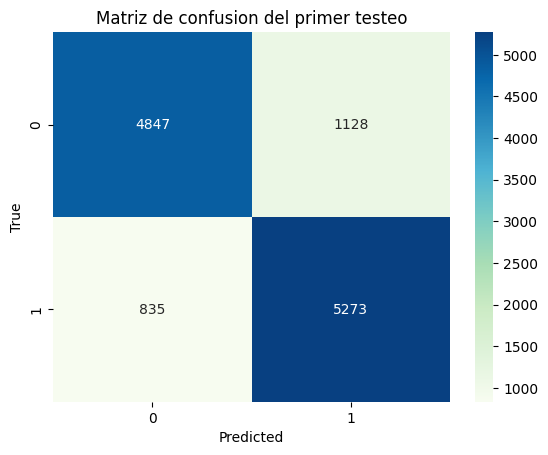

In [454]:
#MATRIZ CONFUSION
tabla = confusion_matrix(y_test, y_pred)
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de confusion del primer testeo')

# Classification Report del primer testeo

In [455]:
#Se printea un classification_report que compara los datos reales y los datos predichos.
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.85      0.81      0.83      5975
           1       0.82      0.86      0.84      6108

    accuracy                           0.84     12083
   macro avg       0.84      0.84      0.84     12083
weighted avg       0.84      0.84      0.84     12083



# Exportacion del primer modelo sin optimizar

In [456]:
import joblib
joblib.dump(model, 'modelo_sin_hiperparametro.joblib')

['modelo_sin_hiperparametro.joblib']

# Transformacion y limpieza del dataset de testeo

In [457]:
#Importamos dataSet de testeo
data2 = pd.read_csv('./hotels_test.csv', on_bad_lines='skip')
ds_testeo = data2.copy()

## Dejamos el dataSet de testeo en el mismo estado que el de entrenamiento antes de realizar el testing

### Aplicamos modificaciones iniciales

In [458]:
ds_testeo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26535 entries, 0 to 26534
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           26535 non-null  object 
 1   lead_time                       26535 non-null  int64  
 2   arrival_date_year               26535 non-null  int64  
 3   arrival_date_month              26535 non-null  object 
 4   arrival_date_week_number        26535 non-null  int64  
 5   arrival_date_day_of_month       26535 non-null  int64  
 6   stays_in_weekend_nights         26535 non-null  int64  
 7   stays_in_week_nights            26535 non-null  int64  
 8   adults                          26535 non-null  int64  
 9   children                        26535 non-null  float64
 10  babies                          26535 non-null  int64  
 11  meal                            26535 non-null  object 
 12  country                         

In [459]:
#Se pasan los meses de string a su valor en numero
meses_a_numeros = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12
}
ds_testeo['arrival_date_month'] = ds_testeo['arrival_date_month'].map(meses_a_numeros)

#Nos ocupamos de las demas columnas con problemas
variables_flotantes = ["children", "agent"]
for categoria in variables_flotantes:
  ds_testeo[categoria].fillna(-10000, inplace=True)
  ds_testeo[categoria] = ds_testeo[categoria].astype('Int64')
  ds_testeo[categoria].replace(-10000, np.nan, inplace=True)

#Creamos la nueva columna "high_season_month"
mediana_meses = ds_testeo['arrival_date_month'].value_counts().median()
ds_testeo['high_season_month'] = ds_testeo['arrival_date_month'].apply(lambda x: 1 if ds_testeo['arrival_date_month'].value_counts()[x] > mediana_meses else 0)
ds_testeo['high_season_month'].value_counts()

#Corregimos los valores de adultos y bebes mal ingresados
condicion_adults_babies_mal_ingresados = (ds_testeo['adults'] <= 0) & (ds_testeo['babies'] > 0)
mediana_children = ds_testeo.loc[condicion_adults_babies_mal_ingresados, 'children'].median()
mediana_babies = ds_testeo.loc[condicion_adults_babies_mal_ingresados, 'babies'].median()

condicion_valor_mas_probable_para_adults =  (ds_testeo['children'] == mediana_children) & (ds_testeo['babies'] == mediana_babies)
mediana_adults = ds_testeo.loc[condicion_valor_mas_probable_para_adults, 'adults'].median()
ds_testeo.loc[condicion_adults_babies_mal_ingresados, 'adults'] = mediana_adults

#Corregimos "Agent"
ds_testeo['agent'].fillna(-1, inplace=True)

#Imprimo las columnas con valores nulos
columnas_con_na = ds_testeo.columns[ds_testeo.isna().any()].tolist()
print("Columnas con valores faltantes:")
for columna in columnas_con_na:
    print(f"{columna}: {ds_testeo[columna].isna().sum()} valores faltantes")

#Nos ocupamos de los NaN de "country"
ds_testeo['country'].fillna(ds_testeo.country.mode()[0], inplace=True)

#Eliminamos columnas consideradas despreciables
variables_inusables = ['id','arrival_date_week_number', 'company', 'reservation_status_date']
ds_testeo.drop(variables_inusables, axis='columns', inplace = True)

#Corregimos problemas de variacion de posibles valores en las columnas entre train y test
ds_testeo["assigned_room_type_L"] = 0

#Chequeamos nulls por columna
print(ds_testeo.isna().sum())

#Vemos el tamaño del dataSet luego de las modificaciones
ds_testeo.shape

Columnas con valores faltantes:
country: 95 valores faltantes
company: 25218 valores faltantes
hotel                             0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
days_in_waiting_list              0
customer_type                     0
adr                               0
requi

(26535, 29)

### Aplicamos ultimas modificaciones

In [460]:
#Encodeamos "country" en 6 categorias. 5 categorias, una para cada pais Top 5, y una ultima categoria que abarca todos los demas paises.
ds_testeo['belonging_country'] = ds_testeo['country'].where(ds_testeo['country'].isin(ds_testeo['country'].value_counts().nlargest(6).index), 'Others')
ds_testeo.drop('country',axis=1, inplace=True)

#Convertimos los meses de su string a su numero de mes
month_number = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12
}
ds_testeo['arrival_date_month'] = ds_testeo['arrival_date_month'].map(month_number)

#Defino las variables categoricas a las que debo aplicar transformaciones
variables_categoricas = ds_testeo.select_dtypes(include=['object']).columns.tolist()
variables_categoricas.append("arrival_date_month")
print(variables_categoricas)

#Imprimimos la cantidad de valores posibles de cada una de las variables categoricas.
ds_testeo[variables_categoricas].nunique()

['hotel', 'meal', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type', 'belonging_country', 'arrival_date_month']


hotel                    2
meal                     5
market_segment           7
distribution_channel     4
reserved_room_type      10
assigned_room_type      11
deposit_type             3
customer_type            4
belonging_country        7
arrival_date_month       0
dtype: int64

In [461]:
#Aplico one hot encoding a las variables categoricas
ds_testeo = pd.get_dummies(ds_testeo, columns = variables_categoricas, drop_first=True)

#Chequeamos que no hayan quedado variables de tipo object
variables_tipo_object = ds_testeo.select_dtypes(include=['object']).columns.tolist()
print(variables_tipo_object)

#Mostramos el tamaño del dataframe y la cantidad de filas con valores nulos
print(ds_testeo.shape)
total_nulos = ds_testeo.isna().sum().sum()
print("Cantidad total de valores nulos:", total_nulos)

# Eliminar las filas con valores nulos de forma permanente
ds_testeo.dropna(inplace=True)

#Mostramos el tamaño del dataframe y la cantidad de filas con valores nulos luego de la eliminacion
total_nulos = ds_testeo.isna().sum().sum()
print("Cantidad total de valores nulos luego de la eliminacion:", total_nulos)
print(ds_testeo.shape)

#Chequeamos como quedo la data
ds_testeo.head()

#Reordenamos las columnas para que coincidan con las de entrenamiento
ds_testeo = ds_testeo[x_train.columns.tolist()]

[]
(26535, 63)
Cantidad total de valores nulos: 0
Cantidad total de valores nulos luego de la eliminacion: 0
(26535, 63)


# Testeo del dataset de test


In [462]:
prediccion = model.predict(ds_testeo)

# Exportacion de la prediccion hecha

In [463]:
#exporto la prediccion
df_submission = pd.DataFrame({'id': data2['id'], 'is_canceled': prediccion})
df_submission.head()

,id,is_canceled
0,e6d0d58a-ab96-44d3-b28f-85df1cc15f1e,1
1,aba9aac2-4495-4645-a60e-90328713c999,1
2,b345b5dc-c804-4d77-a39f-1f4e65d1f1ad,0
3,ce1b400e-afa1-4946-bdff-004b859eb61c,1
4,c4fbec0d-8e2e-4db2-9d4f-a6ccb9f51214,1


In [464]:
df_submission.to_csv('sin_hiperparametro.csv', index=False)

# Grafico del arbol creado

In [465]:
#Grafico arbol sin optimizar
plt.figure(figsize=(100,100))

tree_plot_completo = tree.plot_tree(model, feature_names = ds_trabajo_x.columns.to_list(), filled=True, rounded=True, class_names=['not_cancelled','cancelled'], max_depth = 5)
plt.show(tree_plot_completo)

# Optimizacion de hiperparametros

## Importacion de librerias

In [466]:
from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, f1_score

## Optimizacion

In [467]:
from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, f1_score

combinaciones = 15
folds = 15
params_grid = {'criterion':['gini','entropy'], 'min_samples_leaf':list(range(1,6)), 'min_samples_split': list(range(2,11)), 'max_depth':list(range(10,31))}
kfoldcv = StratifiedKFold(n_splits=folds)
base_tree = DecisionTreeClassifier()
scorer_fn = make_scorer(f1_score)
randomcv = RandomizedSearchCV(estimator = base_tree, param_distributions = params_grid, scoring = scorer_fn, cv = kfoldcv, n_iter = combinaciones, random_state = 7)

#Entreno el modelo
randomcv.fit(x_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=15, random_state=None, shuffle=False),
                   estimator=DecisionTreeClassifier(), n_iter=15,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20, 21,
                                                      22, 23, 24, 25, 26, 27,
                                                      28, 29, 30],
                                        'min_samples_leaf': [1, 2, 3, 4, 5],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10]},
                   random_state=7, scoring=make_scorer(f1_score))

## Mostramos resultados de la optimizacion

In [468]:
print("Mejores resultados: ")
print(randomcv.best_params_)
print()
print("Mejor resultado obtenido de busqueda aleatoria: ")
print("f1_score = ",randomcv.best_score_)

# Valores estadisticos de f1_score
randomcv.cv_results_['mean_test_score']

Mejores resultados: 
{'min_samples_split': 7, 'min_samples_leaf': 1, 'max_depth': 16, 'criterion': 'entropy'}

Mejor resultado obtenido de busqueda aleatoria: 
f1_score =  0.8513646260552663


array([0.84814957, 0.85136463, 0.84285911, 0.84226508, 0.84015161,
       0.84951253, 0.83450744, 0.84200377, 0.84810881, 0.85071406,
       0.84701422, 0.84230876, 0.84021884, 0.84855613, 0.84861179])

## Implementacion de las optimizaciones sobre un arbol

In [469]:
#Creo el árbol con los mejores hiperparámetros
from sklearn.tree import export_text

tree = DecisionTreeClassifier().set_params(**randomcv.best_params_)

#Entreno el arbol en todo el set
tree.fit(x_train,y_train)

#print reglas de decision
reglas = export_text(tree, feature_names = list(ds_trabajo_x.columns.tolist()))
print(reglas)

|--- deposit_type_Non Refund <= 0.50
|   |--- required_car_parking_spaces <= 0.50
|   |   |--- lead_time <= 8.50
|   |   |   |--- belonging_country_PRT <= 0.50
|   |   |   |   |--- agent <= 8.50
|   |   |   |   |   |--- previous_cancellations <= 0.50
|   |   |   |   |   |   |--- agent <= 2.00
|   |   |   |   |   |   |   |--- market_segment_Online TA <= 0.50
|   |   |   |   |   |   |   |   |--- lead_time <= 2.50
|   |   |   |   |   |   |   |   |   |--- adults <= 1.50
|   |   |   |   |   |   |   |   |   |   |--- assigned_room_type_D <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 6
|   |   |   |   |   |   |   |   |   |   |--- assigned_room_type_D >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |--- adults >  1.50
|   |   |   |   |   |   |   |   |   |   |--- agent <= 0.00
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 5
|   |   |   |   |   |   |   |   |   |   |--- agent >  

## Grafico del arbol optimizado

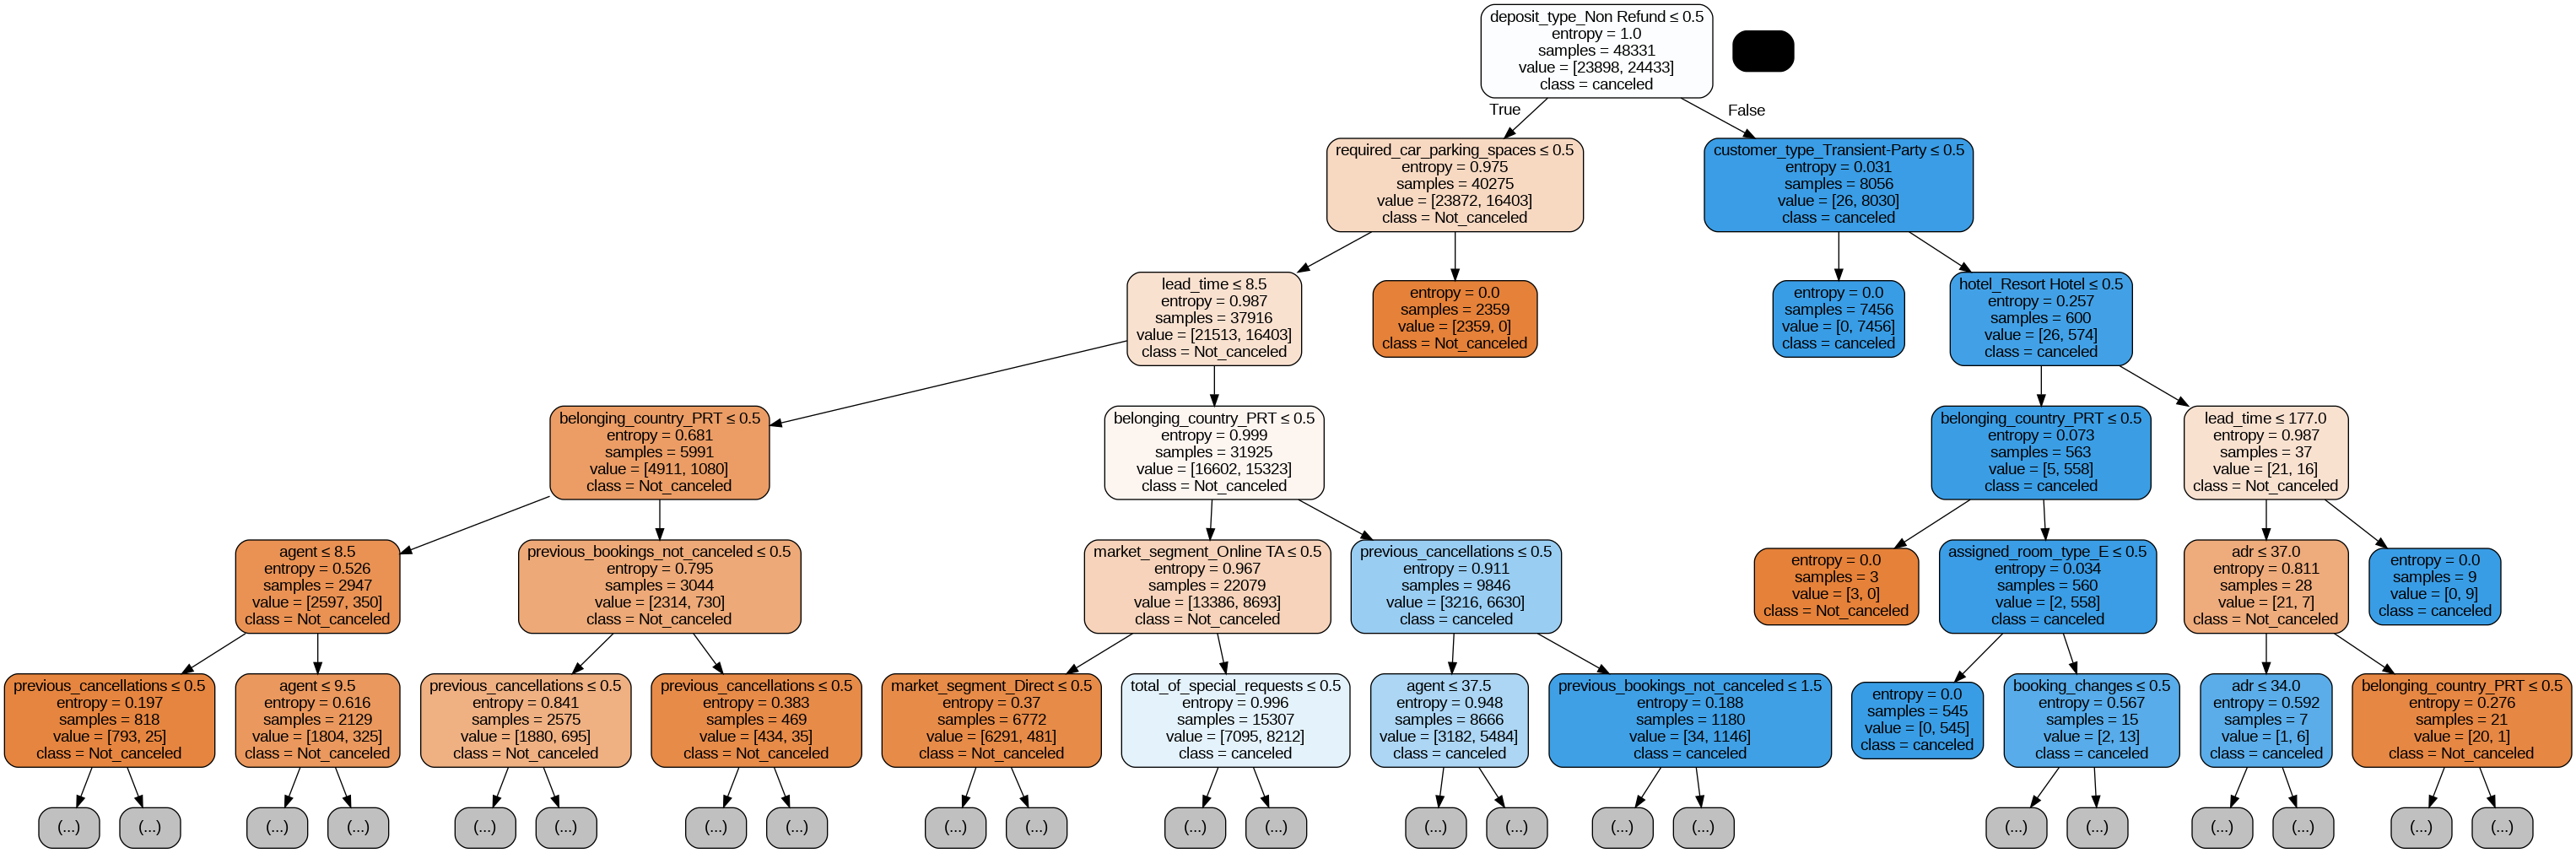

In [471]:
from six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(tree, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True,
                feature_names=ds_trabajo_x.columns.tolist(),
                class_names=['Not_canceled','canceled'],
                max_depth=5)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

## Evaluacion del arbol optimizado

F1-Score: 0.8577589649389027


Text(0.5, 1.0, 'matriz de confusion del modelo optimizado')

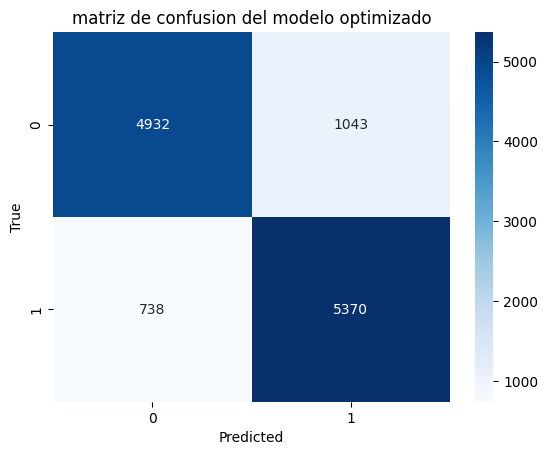

In [472]:
#Evalúo el Arbol con los mejores hiperparámetros
y_pred = tree.predict(x_test)

print('F1-Score: {}'.format(f1_score(y_test, y_pred, average='binary')))
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("matriz de confusion del modelo optimizado")

# Obtencion de la prediccion final

In [475]:
#Realizamos una predicción sobre el set de test
y_pred_final = tree.predict(ds_testeo)

#Valores Predichos
y_pred_final

ds_submission = pd.DataFrame({'id': data2['id'], 'is_canceled': y_pred_final})
ds_submission.to_csv('./prediccion_final.csv', index=False)